In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import multiprocessing
import time
from qutip import *
from qiskit.circuit.library import CRXGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import IfElseOp
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit_experiments.library import StateTomography
from math import pi

# ----------------------------
# Connect to IBM Quantum Service
# ----------------------------
service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/c9a9b9d7c5bd452daa3229a9a4dc4056:d3802968-f622-4b53-94c7-f99f2ccb081b::',
    token='4OFBI96RqSuBi4vozv8sQ1lic25Ko6s9XA9tYUtN7Xle',
)
# ----------------------------
# Backend setup
# ----------------------------


# Get all CPU cores for parallelization
num_cores = multiprocessing.cpu_count()
print(f"Using {num_cores} CPU threads for simulation")
backend = service.backend("ibm_torino")  # replace with your desired backend name
# Configure the Aer simulator for max performance
backend = AerSimulator(
    method='statevector',            # fastest method for most circuits
    max_parallel_threads=num_cores,  # use all cores
    max_parallel_experiments=num_cores,  # parallelize experiments if possible
    blocking_enable=False,           # non-blocking execution
    precision='double'               # you can set 'single' to reduce memory & boost speed
).from_backend(backend)


backend = service.backend("ibm_torino")  # replace with your desired backend name
# ----------------------------
# Sampler setup
# ----------------------------
sampler = SamplerV2(mode=backend)
sampler.options.experimental = {"execution_path": "gen3-experimental"}

# ----------------------------
# Preset transpiler pass manager
# ----------------------------
pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend
)


qiskit_runtime_service._discover_account:WARNING:2026-02-08 11:37:33,842: Loading account with the given token. A saved account will not be used.


Using 14 CPU threads for simulation


In [77]:
from qiskit import *

#Measuring 01 error 
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

qc.measure(q, c)

In [ ]:
shots = [4000, 8000, 16000, 32000, 64000, 128000, 256000]

for shot in shots: 
    transpiled_circ = pass_manager.run(qc)
    result = sampler.run([transpiled_circ], shots=shot)
    print(result.job_id())
    data_bin = result.result()[0].data
    attr_name = next(iter(vars(data_bin)))
    counts = getattr(data_bin, attr_name).get_counts()
    print(counts)
    print(counts['1']/shot)

In [23]:
#Measuring 10 error 
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
qc.x(q[0])
qc.measure(q, c)

In [24]:
shots = [4000, 8000, 16000, 32000, 64000, 128000, 256000]

for shot in shots: 
    transpiled_circ = pass_manager.run(qc)
    result = sampler.run([transpiled_circ], shots=shot)
    print(result.job_id())
    data_bin = result.result()[0].data
    attr_name = next(iter(vars(data_bin)))
    counts = getattr(data_bin, attr_name).get_counts()
    print(counts)
    print(counts['0']/shot)

d646s87s6ggc73fimgng
{'1': 3456, '0': 544}
0.136
d646s9ns6ggc73fimgpg
{'0': 1000, '1': 7000}
0.125
d646sbao8gvs73f44k9g
{'1': 14007, '0': 1993}
0.1245625
d646sdjc4tus73ffcn50
{'1': 27828, '0': 4172}
0.130375
d646sh7s6ggc73fimh10
{'1': 55742, '0': 8258}
0.12903125
d646smrtraac73bi1i5g
{'0': 16467, '1': 111533}
0.1286484375
d646t17s6ggc73fimhkg
{'1': 223119, '0': 32881}
0.12844140625


In [29]:
def remote_cx(qc,control, target,commA, commB, creg, creg_index, Delay):
    qc.barrier()
    qc.h(commA)
    qc.cx(commA, commB)
    qc.barrier()
    qc.delay(Delay, commA, unit='us')
    qc.delay(Delay, commB, unit='us')
    qc.cx(control, commA)
    qc.measure(commA, creg[creg_index])
    with qc.if_test((creg[creg_index], 1)):
        qc.x(commA)
        qc.x(commB)
    qc.cx(commB, target)
    qc.h(commB)
    qc.measure(commB, creg[creg_index + 1])
    with qc.if_test((creg[creg_index + 1], 1)):
        qc.z(control)
    qc.reset(commA)
    qc.reset(commB)

In [37]:
q = QuantumRegister(4)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)
#qc.x(q[0])
remote_cx(qc, control = q[0], target = q[3],commA = q[1], commB = q[2], creg = c, creg_index = 0, Delay = 0)
qc.measure(q[0], c[0])
qc.measure(q[3], c[1])


In [40]:
shots = 10000
delays = [0, 5, 10, 15, 20, 30, 40, 50, 60, 70]
for delay in delays: 
    q = QuantumRegister(4)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)
    #qc.x(q[0])
    remote_cx(qc, control = q[0], target = q[3],commA = q[1], commB = q[2], creg = c, creg_index = 0, Delay = delay)
    qc.measure(q[0], c[0])
    qc.measure(q[3], c[1])
    transpiled_circ = pass_manager.run(qc)
    result = sampler.run([transpiled_circ], shots=shots)
    print(result.job_id())
    data_bin = result.result()[0].data
    attr_name = next(iter(vars(data_bin)))
    counts = getattr(data_bin, attr_name).get_counts()
    print(counts)
    print(counts['00']/shots)

d64844fs6ggc73fio1jg
{'00': 7419, '10': 1484, '01': 606, '11': 491}
0.7419
d64846bc4tus73ffe8kg
{'00': 7152, '11': 465, '10': 1729, '01': 654}
0.7152
d64848btraac73bi312g
{'00': 7020, '10': 1868, '11': 521, '01': 591}
0.702
d6484a3c4tus73ffe8og
{'11': 519, '10': 2002, '00': 6832, '01': 647}
0.6832
d6484cbc4tus73ffe8r0
{'00': 6764, '01': 690, '10': 2034, '11': 512}
0.6764
d6484ebtraac73bi319g
{'00': 6427, '10': 2316, '01': 667, '11': 590}
0.6427
d6484gns6ggc73fio260
{'00': 6057, '10': 2745, '01': 634, '11': 564}
0.6057
d6484ijc4tus73ffe980
{'00': 6040, '01': 647, '10': 2632, '11': 681}
0.604
d6484kbtraac73bi31jg
{'00': 6007, '01': 677, '10': 2683, '11': 633}
0.6007
d6484mjtraac73bi31m0
{'00': 6007, '10': 2646, '01': 673, '11': 674}
0.6007


In [42]:
shots = 10000
delays = [0, 5, 10, 15, 20, 30, 40, 50, 60, 70]
for delay in delays: 
    q = QuantumRegister(4)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)
    qc.x(q[0])
    remote_cx(qc, control = q[0], target = q[3],commA = q[1], commB = q[2], creg = c, creg_index = 0, Delay = delay)
    qc.measure(q[0], c[0])
    qc.measure(q[3], c[1])
    transpiled_circ = pass_manager.run(qc)
    result = sampler.run([transpiled_circ], shots=shots)
    print(result.job_id())
    data_bin = result.result()[0].data
    attr_name = next(iter(vars(data_bin)))
    counts = getattr(data_bin, attr_name).get_counts()
    print(counts)
    print(counts['11']/shots)

d6485e3traac73bi32ig
{'11': 6486, '00': 688, '10': 773, '01': 2053}
0.6486
d6485frtraac73bi32l0
{'01': 2247, '11': 6097, '10': 824, '00': 832}
0.6097
d6485i3c4tus73ffead0
{'11': 5783, '10': 835, '00': 954, '01': 2428}
0.5783
d6485jrc4tus73ffeafg
{'11': 5660, '01': 2366, '00': 1099, '10': 875}
0.566
d6485lqo8gvs73f4645g
{'11': 5497, '01': 2439, '00': 1165, '10': 899}
0.5497
d6485nns6ggc73fio3qg
{'11': 5030, '01': 2632, '10': 948, '00': 1390}
0.503
d6485pjtraac73bi32u0
{'11': 4704, '01': 2763, '10': 1040, '00': 1493}
0.4704
d6485rjtraac73bi3300
{'11': 4472, '00': 1720, '01': 2728, '10': 1080}
0.4472
d6485tvs6ggc73fio410
{'11': 4431, '00': 1846, '01': 2622, '10': 1101}
0.4431
d6485vvs6ggc73fio43g
{'00': 1989, '11': 4060, '01': 2653, '10': 1298}
0.406


In [45]:
shots = 10000
delays = [0, 5, 10, 15, 20, 30, 40, 50, 60, 70]

for delay in delays:
        q = QuantumRegister(4)
        c = ClassicalRegister(2)
        qc = QuantumCircuit(q, c)
        #qc.x(q[0])
        qc.h(q[1])
        qc.cx(q[1], q[2])
        qc.barrier()
        qc.delay(delay, q[1], unit='us')
        qc.delay(delay, q[2], unit='us')
        qc.cx(0, 1)
        # Measure qubit 2
        qc.measure(1, 0)
        # Conditional operations using if_test
        with qc.if_test((0, 1)):
            qc.x(1)
            qc.x(2)
        qc.h(0)
        qc.measure(0, 1)
        with qc.if_test((1, 1)):
            qc.x(0)
            qc.z(2)
        qc.barrier()
        qc.cx(2, 3)
        qc.barrier()
        # Measure remaining qubits
        qc.measure(2, 0)
        qc.measure(3, 1)
        qc.barrier()
        transpiled_circ = pass_manager.run(qc)
        result = sampler.run([transpiled_circ], shots=shots)
        print(result.job_id())
        data_bin = result.result()[0].data
        attr_name = next(iter(vars(data_bin)))
        counts = getattr(data_bin, attr_name).get_counts()
        print(counts)
        print(counts['00']/shots)

d648kq7s6ggc73fioscg
{'00': 8819, '11': 894, '10': 143, '01': 144}
0.8819
d648ks3traac73bi3q70
{'00': 8551, '11': 1135, '01': 169, '10': 145}
0.8551
d648kuao8gvs73f46r4g
{'00': 8348, '11': 1354, '10': 145, '01': 153}
0.8348
d648l0bc4tus73fff34g
{'11': 1565, '00': 8117, '10': 142, '01': 176}
0.8117
d648l2btraac73bi3qg0
{'00': 7768, '11': 1872, '01': 168, '10': 192}
0.7768
d648l4btraac73bi3qig
{'11': 2079, '00': 7499, '01': 203, '10': 219}
0.7499
d648l6ns6ggc73fiosvg
{'11': 2338, '00': 7188, '01': 231, '10': 243}
0.7188
d648l8ns6ggc73fiot40
{'00': 7058, '11': 2518, '10': 216, '01': 208}
0.7058
d648larc4tus73fff3og
{'00': 6766, '11': 2768, '10': 247, '01': 219}
0.6766
d648ld3traac73bi3r30
{'00': 6622, '11': 2834, '01': 274, '10': 270}
0.6622


In [46]:
shots = 10000
delays = [0, 5, 10, 15, 20, 30, 40, 50, 60, 70]

for delay in delays:
        q = QuantumRegister(4)
        c = ClassicalRegister(2)
        qc = QuantumCircuit(q, c)
        qc.x(q[0])
        qc.h(q[1])
        qc.cx(q[1], q[2])
        qc.barrier()
        qc.delay(delay, q[1], unit='us')
        qc.delay(delay, q[2], unit='us')
        qc.cx(0, 1)
        # Measure qubit 2
        qc.measure(1, 0)
        # Conditional operations using if_test
        with qc.if_test((0, 1)):
            qc.x(1)
            qc.x(2)
        qc.h(0)
        qc.measure(0, 1)
        with qc.if_test((1, 1)):
            qc.x(0)
            qc.z(2)
        qc.barrier()
        qc.cx(2, 3)
        qc.barrier()
        # Measure remaining qubits
        qc.measure(2, 0)
        qc.measure(3, 1)
        qc.barrier()
        transpiled_circ = pass_manager.run(qc)
        result = sampler.run([transpiled_circ], shots=shots)
        print(result.job_id())
        data_bin = result.result()[0].data
        attr_name = next(iter(vars(data_bin)))
        counts = getattr(data_bin, attr_name).get_counts()
        print(counts)
        print(counts['11']/shots)

d648m0rc4tus73fff4hg
{'00': 1367, '11': 7581, '01': 543, '10': 509}
0.7581
d648m2qo8gvs73f46so0
{'11': 7130, '00': 1838, '10': 483, '01': 549}
0.713
d648m4jtraac73bi3s0g
{'00': 1944, '11': 7170, '10': 365, '01': 521}
0.717
d648m6bc4tus73fff4tg
{'11': 6938, '00': 2251, '10': 327, '01': 484}
0.6938
d648m8bc4tus73fff520
{'11': 6544, '01': 434, '10': 494, '00': 2528}
0.6544
d648mh3traac73bi3sj0
{'11': 6170, '00': 2938, '01': 436, '10': 456}
0.617
d648mjbc4tus73fff5hg
{'11': 5799, '00': 3379, '01': 391, '10': 431}
0.5799
d648mljtraac73bi3sp0
{'11': 5548, '00': 3592, '10': 423, '01': 437}
0.5548
d648mnjc4tus73fff5p0
{'00': 3843, '11': 5382, '10': 399, '01': 376}
0.5382
d648mpns6ggc73fiovf0
{'00': 3987, '11': 5249, '01': 353, '10': 411}
0.5249


In [60]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Cat-comm remote CNOT with mid-circuit readout error POVM
# (No QuTiP needed; pure NumPy + Matplotlib)
#
# Qubit order (4 qubits total):
#   q0 = control, q1 = target, q2 = commA, q3 = commB
#
# Mid-circuit measurement model (classical readout confusion):
#   e01 = P(report 1 | true 0)  (0->1)
#   e10 = P(report 0 | true 1)  (1->0)
#
# POVM elements (your notation):
#   P0 = (1-e01)|0><0| + e10|1><1|
#   P1 = (1-e10)|1><1| + e01|0><0|
#
# Instrument used here:
#   K_{r,m} = sqrt(p(r|m)) |m><m|
# where m is the true projective outcome, r is the reported outcome.
# ============================================================

def kron(*ms):
    out = np.array([[1.0]], dtype=complex)
    for m in ms:
        out = np.kron(out, m)
    return out

# 1-qubit primitives
I2 = np.eye(2, dtype=complex)
X  = np.array([[0, 1], [1, 0]], dtype=complex)
Z  = np.array([[1, 0], [0,-1]], dtype=complex)
H  = (1/np.sqrt(2))*np.array([[1, 1], [1,-1]], dtype=complex)
P0 = np.array([[1,0],[0,0]], dtype=complex)
P1 = np.array([[0,0],[0,1]], dtype=complex)

# ------------------------------------------------------------
# Embed 1-qubit gate into 4 qubits
# ------------------------------------------------------------
def one_qubit_gate(g, q):
    ops = [I2, I2, I2, I2]
    ops[q] = g
    return kron(*ops)

# ------------------------------------------------------------
# 4-qubit CNOT unitary (computational basis)
# ------------------------------------------------------------
def cnot_4(control, target):
    dim = 16
    U = np.zeros((dim, dim), dtype=complex)
    for i in range(dim):
        bits = [(i >> k) & 1 for k in reversed(range(4))]  # [q0,q1,q2,q3]
        if bits[control] == 1:
            bits[target] ^= 1
        j = 0
        for b in bits:
            j = (j << 1) | b
        U[j, i] = 1
    return U

# ------------------------------------------------------------
# Partial trace out ancillas (commA, commB) keeping control+target
# ------------------------------------------------------------
def partial_trace_ancillas(rho_16):
    # reshape indices: (sys, anc, sys, anc) with sys dim=4 anc dim=4
    rho = rho_16.reshape(4, 4, 4, 4)
    # trace over anc index
    return np.einsum("s a t a -> s t", rho)

# ------------------------------------------------------------
# Measurement instrument Kraus operators for "reported bit" r
# ------------------------------------------------------------
def meas_kraus(e01, e10, which_qubit):
    """
    Returns kraus[r] = list of Kraus operators (16x16) for reported r in {0,1}.
    e01 = P(report 1 | true 0)
    e10 = P(report 0 | true 1)
    """
    # p(r | m) where m is true projective outcome (0 or 1)
    probs = {
        (0,0): 1 - e01,
        (1,0): e01,
        (0,1): e10,
        (1,1): 1 - e10,
    }
    proj = {0: P0, 1: P1}
    kraus = {0: [], 1: []}
    for r in (0,1):
        for m in (0,1):
            p = probs[(r, m)]
            if p <= 0:
                continue
            K = np.sqrt(p) * one_qubit_gate(proj[m], which_qubit)
            kraus[r].append(K)
    return kraus

# ------------------------------------------------------------
# Apply the cat-comm remote CNOT protocol as a channel on 2 qubits
# ------------------------------------------------------------
# Precompute fixed unitaries (speed)
U_H_commA = one_qubit_gate(H, 2)
U_H_commB = one_qubit_gate(H, 3)

U_CX_A_B  = cnot_4(2, 3)  # commA -> commB
U_CX_c_A  = cnot_4(0, 2)  # control -> commA
U_CX_B_t  = cnot_4(3, 1)  # commB -> target

U_XA = one_qubit_gate(X, 2)
U_XB = one_qubit_gate(X, 3)
U_Zc = one_qubit_gate(Z, 0)
U_XA_XB = U_XA @ U_XB

# Ancillas start in |00><00| on (commA, commB)
ket0 = np.array([[1],[0]], dtype=complex)
ket00 = kron(ket0, ket0)
rho_anc = ket00 @ ket00.conj().T  # 4x4

def apply_protocol_to_ct(rho_ct, e01, e10):
    """
    Input: rho_ct (4x4) on (control,target)
    Output: rho_out (4x4) on (control,target)
    """
    # Lift to 4 qubits with ancillas |00>
    rho = np.kron(rho_ct, rho_anc)  # 16x16

    # H(commA); CX(commA->commB); CX(control->commA)
    rho = U_H_commA @ rho @ U_H_commA.conj().T
    rho = U_CX_A_B  @ rho @ U_CX_A_B.conj().T
    rho = U_CX_c_A  @ rho @ U_CX_c_A.conj().T

    # Measure commA (noisy report); if reported 1: X on commA and commB
    krausA = meas_kraus(e01, e10, which_qubit=2)
    rho_after = np.zeros_like(rho)
    for r in (0,1):
        rho_r = np.zeros_like(rho)
        for K in krausA[r]:
            rho_r += K @ rho @ K.conj().T
        if r == 1:
            rho_r = U_XA_XB @ rho_r @ U_XA_XB.conj().T
        rho_after += rho_r
    rho = rho_after

    # CX(commB->target); H(commB)
    rho = U_CX_B_t  @ rho @ U_CX_B_t.conj().T
    rho = U_H_commB @ rho @ U_H_commB.conj().T

    # Measure commB (noisy report); if reported 1: Z on control
    krausB = meas_kraus(e01, e10, which_qubit=3)
    rho_after = np.zeros_like(rho)
    for r in (0,1):
        rho_r = np.zeros_like(rho)
        for K in krausB[r]:
            rho_r += K @ rho @ K.conj().T
        if r == 1:
            rho_r = U_Zc @ rho_r @ U_Zc.conj().T
        rho_after += rho_r
    rho = rho_after

    # Trace out commA, commB
    return partial_trace_ancillas(rho)

# ------------------------------------------------------------
# Average gate fidelity vs ideal CNOT using Choi matrices
# ------------------------------------------------------------
def cnot_2():
    U = np.zeros((4,4), dtype=complex)
    for i in range(4):
        c = (i >> 1) & 1
        t = i & 1
        if c == 1:
            t ^= 1
        j = (c << 1) | t
        U[j, i] = 1
    return U

U_ideal = cnot_2()

def choi_of_unitary(U):
    # J(U) = sum_{ij} (U |i><j| U†) ⊗ |i><j|
    d = U.shape[0]
    J = np.zeros((d*d, d*d), dtype=complex)
    for i in range(d):
        for j in range(d):
            Eij = np.zeros((d,d), dtype=complex)
            Eij[i,j] = 1
            A = U @ Eij @ U.conj().T
            J += np.kron(A, Eij)
    return J

J_ideal = choi_of_unitary(U_ideal)

def choi_of_remote_channel(e01, e10):
    d = 4
    J = np.zeros((d*d, d*d), dtype=complex)
    for i in range(d):
        for j in range(d):
            Eij = np.zeros((d,d), dtype=complex)
            Eij[i,j] = 1
            A = apply_protocol_to_ct(Eij, e01, e10)
            J += np.kron(A, Eij)
    return J

def avg_gate_fidelity(e01, e10):
    d = 4
    J_E = choi_of_remote_channel(e01, e10)
    # entanglement fidelity relative to ideal unitary:
    Fe = np.trace(J_ideal.conj().T @ J_E) / (d**2)
    Fe = np.real_if_close(Fe).item()
    return float(np.real((d * Fe + 1) / (d + 1)))

# ------------------------------------------------------------
# Sweep and plot heatmap
# ------------------------------------------------------------
grid_n = 21
e01_vals = np.linspace(0.0, 0.30, grid_n)  # x-axis
e10_vals = np.linspace(0.0, 0.30, grid_n)  # y-axis

F = np.zeros((grid_n, grid_n))
for yi, e10 in enumerate(e10_vals):
    for xi, e01 in enumerate(e01_vals):
        F[yi, xi] = avg_gate_fidelity(e01, e10)


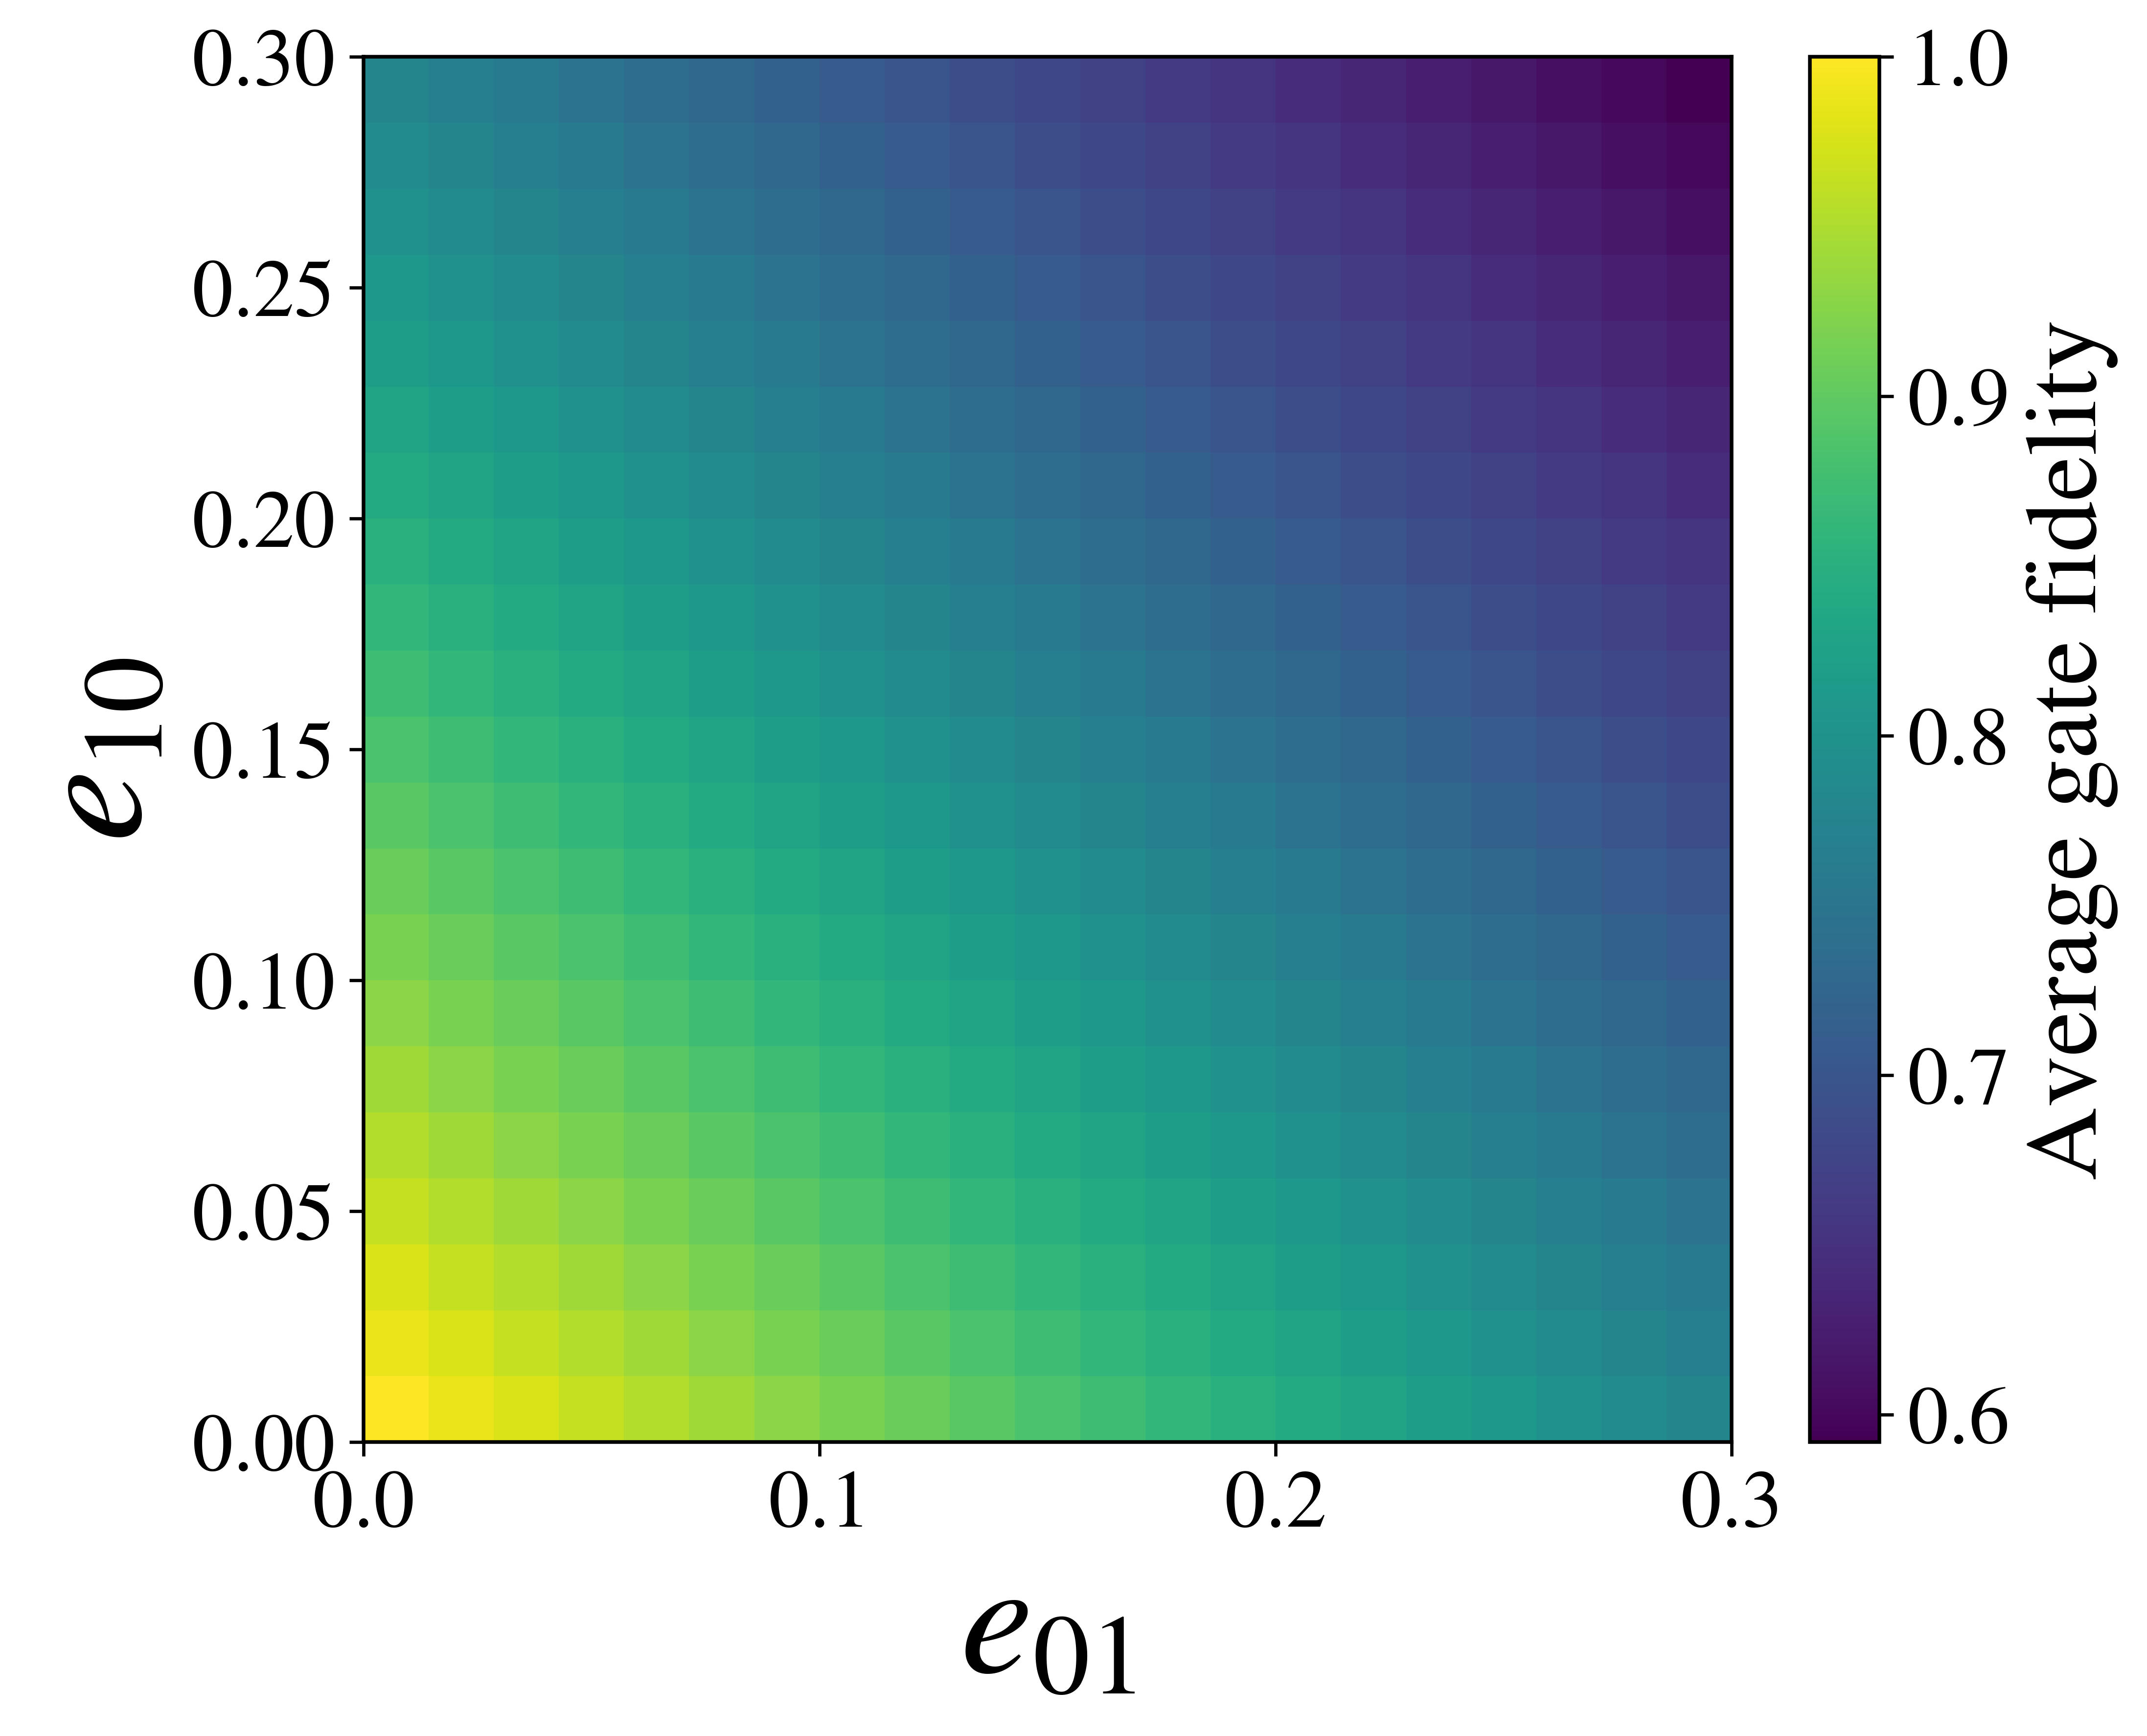

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # Serif + math
    "font.family": "serif",
    "font.serif": ["STIXGeneral", "Times New Roman", "DejaVu Serif"],
    "mathtext.fontset": "stix",

    # Scaled font sizes
    "font.size": 14 ,
    "axes.titlesize": 18,
    "axes.labelsize": 40,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 13,
    "figure.titlesize": 18,

    # Line / axes polish
    "axes.linewidth": 0.9,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,

    # PDF/PS friendliness
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# -------------------- Plot --------------------
fig, ax = plt.subplots(figsize=(7.2, 5.8), dpi=600, constrained_layout=True)

im = ax.imshow(
    F,
    origin="lower",
    aspect="auto",
    extent=[e01_vals[0], e01_vals[-1], e10_vals[0], e10_vals[-1]],
)

ax.set_xlabel(r"$e_{01}$")
ax.set_ylabel(r"$e_{10}$")

cb = fig.colorbar(im, ax=ax, pad=0.02)
cb.set_label("Average gate fidelity", fontsize = 25)

plt.show()


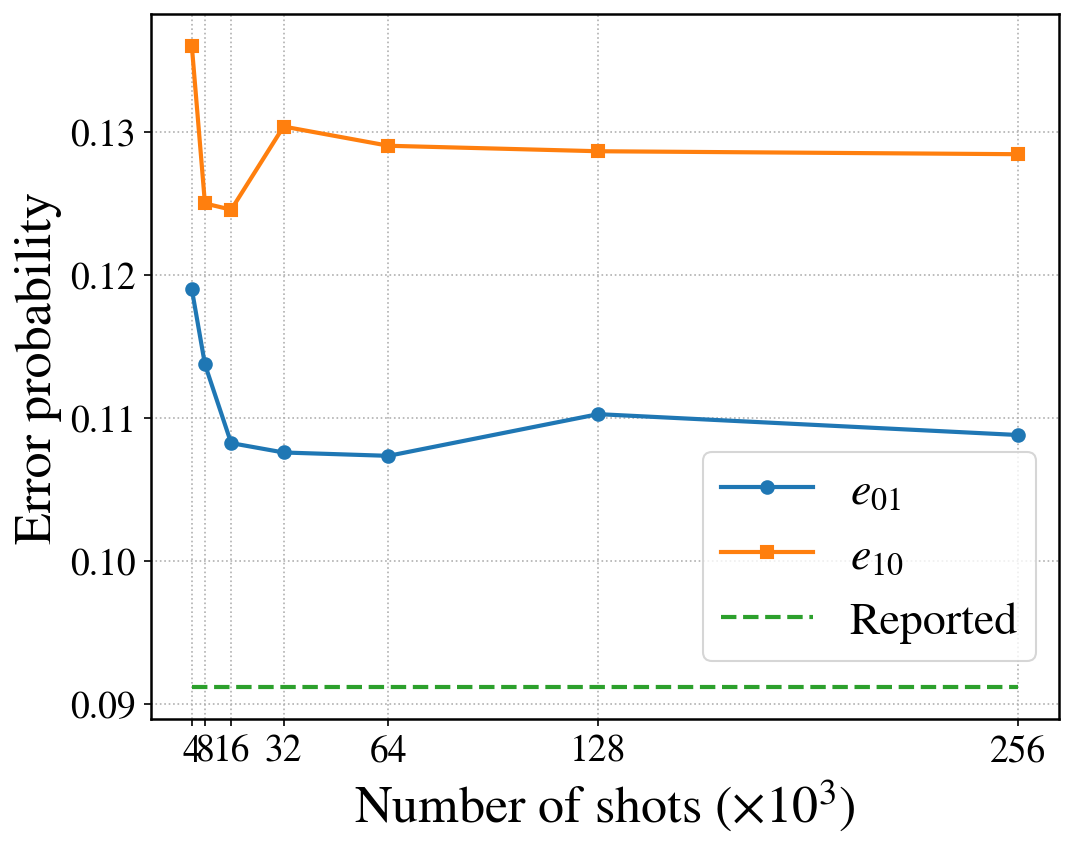

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Data
# ----------------------------
shots = np.array([4000, 8000, 16000, 32000, 64000, 128000, 256000])
shots_scaled = shots / 1e3   # remove zeros cleanly

p_0_to_1 = np.array([
    0.119,
    0.11375,
    0.10825,
    0.10759375,
    0.107359375,
    0.1102734375,
    0.10881640625
])

p_1_to_0 = np.array([
    0.136,
    0.125,
    0.1245625,
    0.130375,
    0.12903125,
    0.1286484375,
    0.12844140625
])

ibm_torino_error = 9.119e-2
torino_curve = np.full(len(shots_scaled), ibm_torino_error)

# ----------------------------
# Styling
# ----------------------------
FONT_SIZE = 18

plt.rcParams.update({
    "font.size": FONT_SIZE,
    "axes.titlesize": FONT_SIZE + 2,
    "axes.labelsize": FONT_SIZE + 7,
    "xtick.labelsize": FONT_SIZE ,
    "ytick.labelsize": FONT_SIZE ,
    "legend.fontsize": FONT_SIZE + 4,
    "axes.linewidth": 1.2,
})

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(7.5, 6), dpi=150)

ax.plot(shots_scaled, p_0_to_1, marker="o", linewidth=2,
        label=r"$e_{01}$")

ax.plot(shots_scaled, p_1_to_0, marker="s", linewidth=2,
        label=r"$e_{10}$")

ax.plot(shots_scaled, torino_curve, linestyle="--", linewidth=2,
        label="Reported")

# Exact ticks at data points
ax.set_xticks(shots_scaled)

# Axis labels (scale communicated HERE)
ax.set_xlabel(r"Number of shots ($\times 10^{3}$)")
ax.set_ylabel("Error probability")


ax.grid(True, linestyle=":", linewidth=0.8)
ax.legend(
    frameon=True,
    loc="lower right",
    bbox_to_anchor=(1.0, 0.05),  # 👈 move legend UP (increase Y)
)

plt.tight_layout()
plt.show()


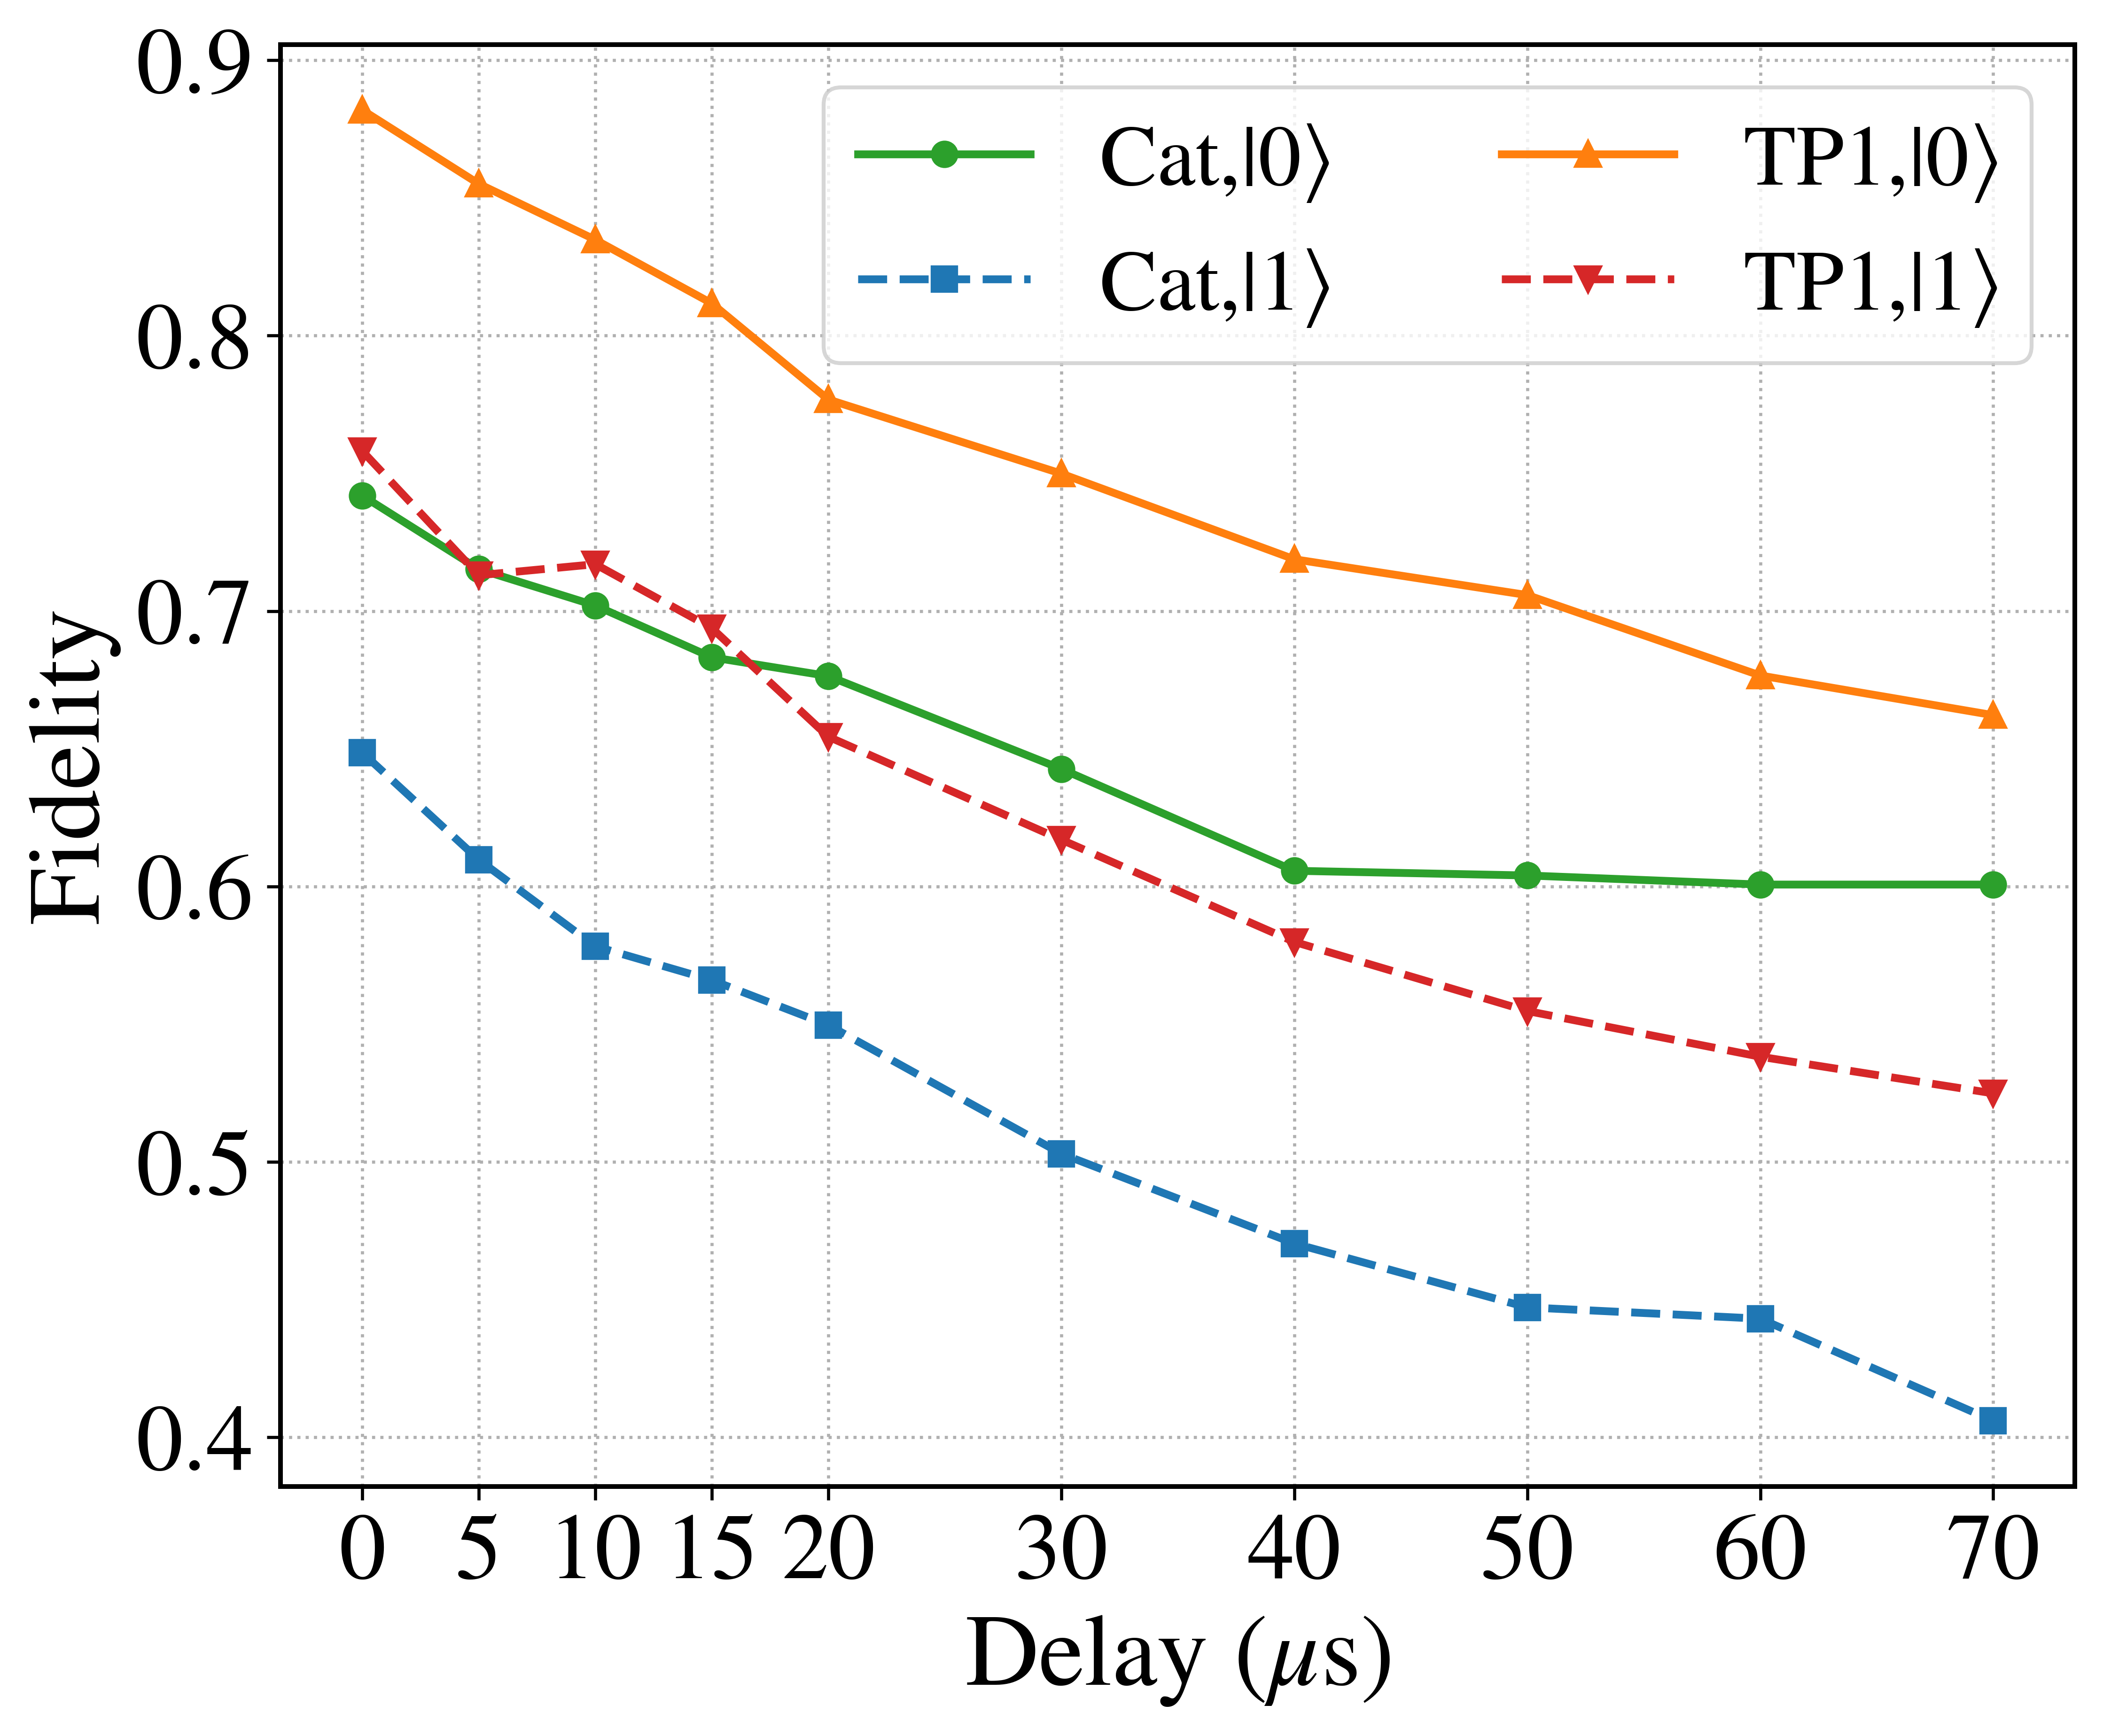

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# X axis: delays (µs)
# ----------------------------
delays = np.array([0, 5, 10, 15, 20, 30, 40, 50, 60, 70], dtype=float)

# ----------------------------
# Data
# ----------------------------
rg_control_0 = np.array([0.7419, 0.7152, 0.7020, 0.6832, 0.6764, 0.6427, 0.6057, 0.6040, 0.6007, 0.6007])
rg_control_1 = np.array([0.6486, 0.6097, 0.5783, 0.5660, 0.5497, 0.5030, 0.4704, 0.4472, 0.4431, 0.4060])

tp1_control_0 = np.array([0.8819, 0.8551, 0.8348, 0.8117, 0.7768, 0.7499, 0.7188, 0.7058, 0.6766, 0.6622])
tp1_control_1 = np.array([0.7581, 0.7130, 0.7170, 0.6938, 0.6544, 0.6170, 0.5799, 0.5548, 0.5382, 0.5249])

# ----------------------------
# Styling (edit FONT_SIZE only)
# ----------------------------
FONT_SIZE = 18

plt.rcParams.update({
    "font.size": FONT_SIZE,
    "axes.titlesize": FONT_SIZE + 2,
    "axes.labelsize": FONT_SIZE + 8,
    "xtick.labelsize": FONT_SIZE + 6,
    "ytick.labelsize": FONT_SIZE + 6,
    "legend.fontsize": FONT_SIZE + 4,
    "axes.linewidth": 1.2,
})

# ----------------------------
# Plot (single panel)
# ----------------------------
fig, ax = plt.subplots(figsize=(7.8, 6.5), dpi=600)

ax.plot(delays, rg_control_0,
        color="tab:green", marker="o", linestyle="-", linewidth=2,
        label=r"Cat,$|0\rangle$")

ax.plot(delays, rg_control_1,
        color="tab:blue", marker="s", linestyle="--", linewidth=2,
        label=r"Cat,$|1\rangle$")

ax.plot(delays, tp1_control_0,
        color="tab:orange", marker="^", linestyle="-", linewidth=2,
        label=r"TP1,$|0\rangle$")

ax.plot(delays, tp1_control_1,
        color="tab:red", marker="v", linestyle="--", linewidth=2,
        label=r"TP1,$|1\rangle$")

# Axes formatting
ax.set_xlabel(r"Delay ($\mu$s)")
ax.set_ylabel("Fidelity")

ax.set_xticks(delays)
ax.grid(True, linestyle=":", linewidth=0.8)

ax.legend(frameon=True, ncol=2)

plt.tight_layout()
plt.show()
